### Bird classification locally

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.utils import img_to_array, load_img

import glob
import os

In [3]:
# Print class names of birds and get num of classes
DATA_PATH = "./../Data/BirdClass/"

n_classes = 0
for folder in glob.glob(os.path.join(DATA_PATH, "train_data/*")):
    print(folder.split("\\")[-1])
    n_classes += 1

blasti
bonegl
brhkyt
cbrtsh
cmnmyn
gretit
hilpig
himbul
himgri
hsparo
indvul
jglowl
lbicrw
mgprob
rebimg
wcrsrt


In [5]:
# Data generators and augmentations

data_augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.4,
    height_shift_range=0.4,
    brightness_range=(0.3, 1),
    zoom_range=0.5,
    horizontal_flip=True,
    rescale=1./255
)
train_gen = data_augmenter.flow_from_directory(
    directory=os.path.join(DATA_PATH, "train_data"),
    target_size=(600, 400),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)
val_gen = data_augmenter.flow_from_directory(
    directory=os.path.join(DATA_PATH, "test_data"),
    target_size=(600, 400),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

Found 150 images belonging to 16 classes.
Found 157 images belonging to 16 classes.


### Plot accuracy of model

In [7]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy per epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'learning_curve_TL.png')
    plt.show()

### CNN Classifier Model
- Three 2D convolutional layers
- Dropout and BatchNorm for each
- Max Pooling layer for each Conv2D feature shrinking
- Flattened into 2 Dense fully connected layers
- and an output FC layer ccorresponding to the multi class labelling

In [18]:
model = Sequential()
model.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(2,2),
    activation='relu',
    input_shape=(600, 400, 3)
))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(
    filters=64, 
    kernel_size=(3,3),
    strides=(2, 2), 
    activation='relu'
))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(
    filters=128, 
    kernel_size=(3,3),
    strides=(2, 2), 
    activation='relu'
))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(n_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer='adam'
)

Epoch 1/20
10/10 [==============================] - 103s 11s/step - loss: 2.8269 - accuracy: 0.1867 - val_loss: 2.8726 - val_accuracy: 0.0955
Epoch 2/20
10/10 [==============================] - 65s 7s/step - loss: 2.5598 - accuracy: 0.2200 - val_loss: 2.8288 - val_accuracy: 0.0446
Epoch 3/20
10/10 [==============================] - 66s 7s/step - loss: 2.3813 - accuracy: 0.2333 - val_loss: 2.9241 - val_accuracy: 0.1210
Epoch 4/20
10/10 [==============================] - 68s 7s/step - loss: 2.2934 - accuracy: 0.2733 - val_loss: 3.0052 - val_accuracy: 0.0382
Epoch 5/20
10/10 [==============================] - 69s 7s/step - loss: 2.2406 - accuracy: 0.3133 - val_loss: 3.1492 - val_accuracy: 0.0573
Epoch 6/20
10/10 [==============================] - 71s 7s/step - loss: 2.2179 - accuracy: 0.2467 - val_loss: 3.0905 - val_accuracy: 0.0446
Epoch 7/20
10/10 [==============================] - 71s 7s/step - loss: 2.2017 - accuracy: 0.2600 - val_loss: 3.0474 - val_accuracy: 0.0573
Epoch 8/20
10/10 [

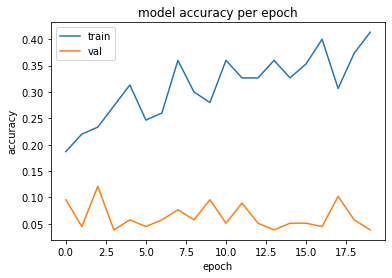

In [19]:
N_EPOCHS = 20
train_history = model.fit(train_gen,
                      batch_size=16,
                      epochs=N_EPOCHS,
                      validation_data=val_gen)

plot_accuracy(train_history)

### Transfer learning

In [6]:
from keras.applications import InceptionV3

feature_extractor = InceptionV3(include_top=False,
                                weights="imagenet",
                                pooling='max',
                                input_shape=(600, 400, 3))
x = feature_extractor.output
x = Dense(512, activation='relu', name='fc_1')(x)
x = Dense(256, activation='relu', name='fc_2')(x)
x = Dense(128, activation='relu', name='fc_3')(x)
outputs = Dense(n_classes, activation='softmax')(x)
Transfer_model = Model(inputs=feature_extractor.inputs, outputs=outputs)

for layer in Transfer_model.layers:
    if layer.name in ['fc_1', 'fc_2', 'fc_3']:
        layer.trainable = True
    else:
        layer.trainable = False

Transfer_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Testing model with sample images

Epoch 1/30
10/10 [==============================] - 138s 13s/step - loss: 6.8304 - accuracy: 0.0733 - val_loss: 4.1243 - val_accuracy: 0.1274
Epoch 2/30
10/10 [==============================] - 97s 10s/step - loss: 3.7415 - accuracy: 0.1067 - val_loss: 3.1678 - val_accuracy: 0.2038
Epoch 3/30
10/10 [==============================] - 82s 9s/step - loss: 2.7919 - accuracy: 0.1733 - val_loss: 2.6326 - val_accuracy: 0.2038
Epoch 4/30
10/10 [==============================] - 86s 9s/step - loss: 2.4883 - accuracy: 0.3000 - val_loss: 2.5065 - val_accuracy: 0.3248
Epoch 5/30
10/10 [==============================] - 86s 9s/step - loss: 2.4820 - accuracy: 0.3000 - val_loss: 2.5837 - val_accuracy: 0.2293
Epoch 6/30
10/10 [==============================] - 89s 9s/step - loss: 2.1780 - accuracy: 0.3333 - val_loss: 2.4661 - val_accuracy: 0.2675
Epoch 7/30
10/10 [==============================] - 83s 9s/step - loss: 1.9988 - accuracy: 0.4467 - val_loss: 2.8260 - val_accuracy: 0.2484
Epoch 8/30
10/10 

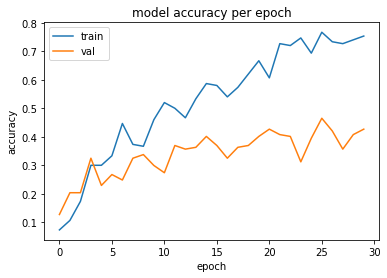

In [8]:
history2 = Transfer_model.fit(train_gen,
                              batch_size=16,
                              epochs=30,
                              validation_data=val_gen)
plot_accuracy(history2)